# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

 Number of reviews: 568,454                                                                                                     
 Number of users: 256,059                                                                                                       
 Number of products: 74,258                                                                                                                                                                                                             
 Number of Attributes/Columns in data: 10
 
 Attributes:
1. IdRow Id
2. ProductIdUnique identifier for the product
3. UserIdUnqiue identifier for the user
4. ProfileNameProfile name of the user
5. HelpfulnessNumeratorNumber of users who found the review helpful
6. HelpfulnessDenominatorNumber of users who indicated whether they found the review helpful
7. ScoreRating between 1 and 5
8. TimeTimestamp for the review
9. SummaryBrief summary of the review
10. TextText of the review

In [123]:
import warnings
warnings.filterwarnings("ignore")

In [124]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import pickle

In [125]:
# Loading 250 pts obtained after data preprocessing and sorting 

with open('C:/Users/U6069188/Python Projects/Pickle/FilteredData_250K','rb') as f:
    FilteredData = pickle.load(f)

In [126]:
#FilteredData = FilteredData.head(1000)

FilteredData["Score"].value_counts()

positive    212075
negative     37925
Name: Score, dtype: int64

In [127]:
X = FilteredData["CleanedText"]
X.shape

(250000,)

In [128]:
y_dict = {'positive':1,'negative':-1}
y = FilteredData['Score'].map(y_dict)

y.shape

(250000,)

In [129]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=.7)

In [130]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

def Run_CV_l2(X_train, y_train,X_test,y_test):
    
    tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    model_grid = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
    model_grid.fit(X_train, y_train)
    
    print(model_grid.best_estimator_)
    
    optimalc_grid = list(model_grid.best_estimator_.get_params().items())[0]
    print('optimal C value using GridSearchCV',optimalc_grid)
    
    print('*'*120)
    
    param_grid = {'C':uniform().rvs(size=10)}
    model_rand = RandomizedSearchCV(LogisticRegression(),param_distributions=param_grid,scoring = 'f1', cv=5)
    model_rand.fit(X_train, y_train)
    
    print(model_rand.best_estimator_)
    optimalc_rand = list(model_rand.best_estimator_.get_params().items())[0]

    print('optimal C value using RandomizedSearchCV',optimalc_rand)
    return optimalc_grid,optimalc_rand,model_grid


def Run_CV_l1(X_train, y_train,X_test,y_test):
    
    C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    
    penalty = ['l1']
    hyperparameters = dict(C=C, penalty=penalty)
    
    model_grid = GridSearchCV(LogisticRegression(), hyperparameters, scoring = 'f1', cv=5)
    model_grid.fit(X_train, y_train)
    
    print(model_grid.best_estimator_)
    
    optimalc_grid = list(model_grid.best_estimator_.get_params().items())[0]
    print('optimal C value using GridSearchCV',optimalc_grid)
    
    print('*'*120)
    
    C = uniform().rvs(size=10)
    hyperparameters = dict(C=C, penalty=penalty)
    model_rand = RandomizedSearchCV(LogisticRegression(),param_distributions=hyperparameters,scoring = 'f1', cv=5)
    model_rand.fit(X_train, y_train)
    
    print(model_rand.best_estimator_)
    optimalc_rand = list(model_rand.best_estimator_.get_params().items())[0]

    print('optimal C value using RandomizedSearchCV',optimalc_rand)
    return optimalc_grid,optimalc_rand,model_grid
    

def Run_LogisticReg(X_train, y_train,X_test,y_test,optimalc,regularizer):
    
    model = LogisticRegression(C=optimalc,penalty = regularizer);
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #Accuracy on train data
    train_acc = model.score(X_train, y_train)
    train_err = 1-train_acc
        
    #Accuracy on test data
    test_acc = accuracy_score(y_test, pred)*100
    test_err = 1- test_acc
        
    print('*'*120)
    print('Optimal C is' ,optimalc)
    print('Accuracy for LogisticReg algorithm with lambda  is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for LogisticReg algorithm with lambda  is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for LogisticReg agorithm with lambda is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for LogisticReg algorithm with lambda is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report for LogisticReg algorithm with lambda is \n ' , classification_report(y_test,pred))
    
    cm= confusion_matrix(y_test, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return train_err,test_err
    
def Run_L1RegTest(X_train, y_train,X_test,y_test,optimalc,regularizer='l1'):
    c = optimalc
    i = 1;
    while i<=5:
        model = LogisticRegression(C=c, penalty= regularizer);
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        w = model.coef_
        print('Sparcity of weigt vector is',np.count_nonzero(w))
        print('Error when C =',c,' is ', 100 - np.round((accuracy_score(y_test, pred)*100),decimals = 2))
        i+=1
        c = c/10



def FeatureImp(X_train,y_train,model,vectorizer):
    w = model.best_estimator_.coef_
    
    B = vectorizer.get_feature_names()
    
    data_df = {'features': B, 'weightvec': list(w)[0]}
    
    df = pd.DataFrame(data = data_df)
    data_nonzero = df[df['weightvec'] != 0]
    
    print(data_nonzero.sort_values('weightvec',ascending = False).head(10))
    

def percentage(x):
    if(x>0):
        x = x*100
    else:
        x = -x*100
    return x

def TestCollinear(X_train,y_train,model,features):
    epsilon = np.random.normal(loc=0.0, scale=0.0000000001)
    
    X_train.data = X_train.data + epsilon
    
    C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    penalty = ['l1']

    hyperparameters = dict(C=C, penalty=penalty)
    model_noise = GridSearchCV(LogisticRegression(), hyperparameters, scoring = 'f1', cv=5)
    model_noise.fit(X_train, y_train)
    w_noise = model_noise.best_estimator_.coef_
    
    w = model.best_estimator_.coef_
    #print(np.nonzero(w))
    data_df = {'features': features, 'weightvec': list(w)[0],'weightvec_noise':list(w_noise)[0]}

    df = pd.DataFrame(data= data_df)

    df = df[df['weightvec'] != 0]
    
    df['diffs'] = (df['weightvec']-df['weightvec_noise'])/(df['weightvec'])
    li = []

    ls = df['diffs']

    for i in ls:
        if i>0:
            i=i*100
        else:
            i=-i*100
        li.append(i)
    
    df['diffs'] = li

    ls = df[df['diffs']>30]
    print('Printing the top 10 values with percentage change in the weights greater than threshold 30 ')
    print('*'*120)
    print(ls.sort_values('diffs',ascending = False).head(10))

# BOW

In [131]:
with open('C:/Users/U6069188/Python Projects/Pickle/Bow','rb') as f:
    bow = pickle.load(f)

In [132]:
features = bow.get_feature_names()

In [133]:
X_train_bow = bow.transform(X_train)

In [134]:
X_test_bow = bow.transform(X_test)

In [135]:
from sklearn.preprocessing import StandardScaler

X_train_bow = StandardScaler(with_mean = False).fit_transform(X_train_bow)
X_train_bow.shape

(175000, 2268298)

In [136]:
X_test_bow = StandardScaler(with_mean = False).fit_transform(X_test_bow)
X_test_bow.shape

(75000, 2268298)

In [137]:
optc_grid_l2_bow,optc_rand_l2_bow,model_grid_l2_bow = Run_CV_l2(X_train_bow, y_train,X_test_bow,y_test)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
optimal C value using GridSearchCV ('C', 1)
************************************************************************************************************************
LogisticRegression(C=0.773725209287023, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
optimal C value using RandomizedSearchCV ('C', 0.773725209287023)


In [138]:
optc_grid_l1_bow,optc_rand_l1_bow,model_grid_l1_bow = Run_CV_l1(X_train_bow, y_train,X_test_bow,y_test)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
optimal C value using GridSearchCV ('C', 0.01)
************************************************************************************************************************
LogisticRegression(C=0.015484725439227742, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
optimal C value using RandomizedSearchCV ('C', 0.015484725439227742)


************************************************************************************************************************
Optimal C is 0.01
Accuracy for LogisticReg algorithm with lambda  is  91.84
F1 score for LogisticReg algorithm with lambda  is  81.51
Recall for LogisticReg agorithm with lambda is  77.06
Precision for LogisticReg algorithm with lambda is  89.32

 Classification report for LogisticReg algorithm with lambda is 
               precision    recall  f1-score   support

         -1       0.86      0.56      0.68     11506
          1       0.92      0.98      0.95     63494

avg / total       0.91      0.92      0.91     75000



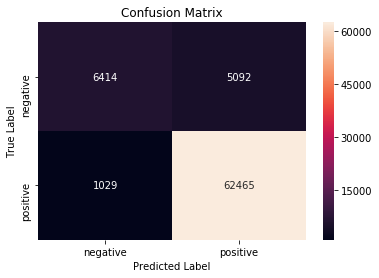

In [139]:
train_err_l1_bow,test_err_l1_bow = Run_LogisticReg(X_train_bow, y_train,X_test_bow,y_test,optc_grid_l1_bow[1],'l1')

************************************************************************************************************************
Optimal C is 1
Accuracy for LogisticReg algorithm with lambda  is  89.83
F1 score for LogisticReg algorithm with lambda  is  74.35
Recall for LogisticReg agorithm with lambda is  69.27
Precision for LogisticReg algorithm with lambda is  88.53

 Classification report for LogisticReg algorithm with lambda is 
               precision    recall  f1-score   support

         -1       0.87      0.40      0.54     11506
          1       0.90      0.99      0.94     63494

avg / total       0.90      0.90      0.88     75000



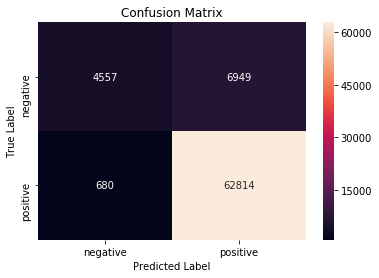

In [140]:
train_err_l2_bow,test_err_l2_bow = Run_LogisticReg(X_train_bow, y_train,X_test_bow,y_test,optc_grid_l2_bow[1],'l2')

In [141]:
Run_L1RegTest(X_train_bow, y_train,X_test_bow,y_test,optc_grid_l1_bow[1])

Sparcity of weigt vector is 70938
Error when C = 0.01  is  8.159999999999997
Sparcity of weigt vector is 318
Error when C = 0.001  is  10.459999999999994
Sparcity of weigt vector is 3
Error when C = 0.0001  is  15.340000000000003
Sparcity of weigt vector is 0
Error when C = 1e-05  is  84.66
Sparcity of weigt vector is 0
Error when C = 1.0000000000000002e-06  is  84.66


In [142]:
FeatureImp(X_train_bow, y_train,model_grid_l1_bow,bow)

               features  weightvec
878624            great   0.832134
1168065            love   0.639564
177071             best   0.567199
523929           delici   0.503288
856886             good   0.456069
1451946         perfect   0.390589
946652   high recommend   0.368588
677252            excel   0.358933
718563          favorit   0.284518
1323043            nice   0.274166


In [143]:
TestCollinear(X_train_bow, y_train,model_grid_l1_bow,features)

Printing the top 10 values with percentage change in the weights greater than threshold 30 
************************************************************************************************************************
               features     weightvec  weightvec_noise         diffs
2175983    wast attempt -3.993533e-10        -0.000445  1.114606e+08
2109943  undercook need -1.350702e-09        -0.001017  7.530711e+07
1467265     pictur nido -2.034462e-09        -0.001059  5.204607e+07
596183          dri guy -6.447385e-09        -0.001498  2.324072e+07
1775889     show disney -6.447385e-09        -0.000983  1.524720e+07
1841248      sorri buck  1.570726e-08         0.001371  8.726180e+06
1130383        like mae -2.316019e-09        -0.000138  5.955593e+06
1480238     plant charg  1.796812e-08         0.001061  5.902367e+06
45066      alloy replac -8.257909e-08        -0.004050  4.904100e+06
2002734     textur blah -1.738488e-08        -0.000742  4.269262e+06


# Tf-Idf

In [144]:
with open('C:/Users/U6069188/Python Projects/Pickle/tfidf','rb') as f:
    tfidf = pickle.load(f)

tfidf = TfidfVectorizer(ngram_range=(1,2)).fit(X_train)

In [145]:
features = tfidf.get_feature_names()

In [146]:
X_train_tfidf = tfidf.transform(X_train)

In [147]:
X_test_tfidf= tfidf.transform(X_test)

In [148]:
from sklearn.preprocessing import StandardScaler

X_train_tfidf = StandardScaler(with_mean = False).fit_transform(X_train_tfidf)
X_train_tfidf.shape

(175000, 1802519)

In [149]:
X_test_tfidf = StandardScaler(with_mean = False).fit_transform(X_test_tfidf)
X_test_tfidf.shape

(75000, 1802519)

In [150]:
optc_grid_l2_tfidf,optc_rand_l2_tfidf,model_grid_l2_tfidf = Run_CV_l2(X_train_tfidf, y_train,X_test_tfidf,y_test)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
optimal C value using GridSearchCV ('C', 100)
************************************************************************************************************************
LogisticRegression(C=0.6119908526979553, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
optimal C value using RandomizedSearchCV ('C', 0.6119908526979553)


In [151]:
optc_grid_l1_tfidf,optc_rand_l1_tfidf,model_grid_l1_tfidf = Run_CV_l1(X_train_tfidf, y_train,X_test_tfidf,y_test)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
optimal C value using GridSearchCV ('C', 0.01)
************************************************************************************************************************
LogisticRegression(C=0.7115075139314194, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
optimal C value using RandomizedSearchCV ('C', 0.7115075139314194)


************************************************************************************************************************
Optimal C is 0.01
Accuracy for LogisticReg algorithm with lambda  is  92.38
F1 score for LogisticReg algorithm with lambda  is  83.05
Recall for LogisticReg agorithm with lambda is  78.82
Precision for LogisticReg algorithm with lambda is  89.97

 Classification report for LogisticReg algorithm with lambda is 
               precision    recall  f1-score   support

         -1       0.87      0.59      0.70     11506
          1       0.93      0.98      0.96     63494

avg / total       0.92      0.92      0.92     75000



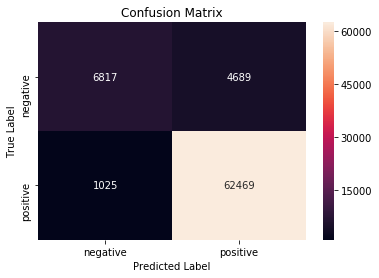

In [152]:
train_err_l1_tfidf,test_err_l1_tfidf = Run_LogisticReg(X_train_tfidf, y_train,X_test_tfidf,y_test,optc_grid_l1_tfidf[1],'l1')

************************************************************************************************************************
Optimal C is 100
Accuracy for LogisticReg algorithm with lambda  is  89.39
F1 score for LogisticReg algorithm with lambda  is  71.6
Recall for LogisticReg agorithm with lambda is  66.47
Precision for LogisticReg algorithm with lambda is  90.98

 Classification report for LogisticReg algorithm with lambda is 
               precision    recall  f1-score   support

         -1       0.93      0.33      0.49     11506
          1       0.89      1.00      0.94     63494

avg / total       0.90      0.89      0.87     75000



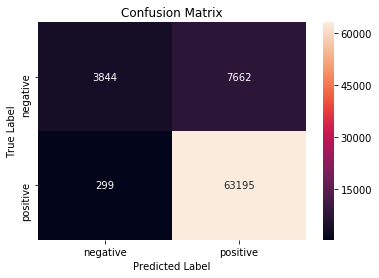

In [153]:
train_err_l2_tfidf,test_err_l2_tfidf = Run_LogisticReg(X_train_tfidf, y_train,X_test_tfidf,y_test,optc_grid_l2_tfidf[1],'l2')

In [154]:
Run_L1RegTest(X_train_tfidf, y_train,X_test_tfidf,y_test,optc_grid_l1_tfidf[1])

Sparcity of weigt vector is 65127
Error when C = 0.01  is  7.6299999999999955
Sparcity of weigt vector is 364
Error when C = 0.001  is  9.920000000000002
Sparcity of weigt vector is 3
Error when C = 0.0001  is  15.340000000000003
Sparcity of weigt vector is 0
Error when C = 1e-05  is  84.66
Sparcity of weigt vector is 0
Error when C = 1.0000000000000002e-06  is  84.66


In [155]:
FeatureImp(X_train_tfidf, y_train,model_grid_l1_tfidf,tfidf)

               features  weightvec
698309            great   0.893343
927848             love   0.695485
140347             best   0.607259
415990           delici   0.514709
680901             good   0.439550
1153923         perfect   0.409925
537709            excel   0.370030
752267   high recommend   0.350008
570430          favorit   0.281984
1050992            nice   0.259014


In [156]:
TestCollinear(X_train_tfidf, y_train,model_grid_l1_tfidf,features)

Printing the top 10 values with percentage change in the weights greater than threshold 30 
************************************************************************************************************************
                 features     weightvec  weightvec_noise         diffs
59555           anoth lap -1.568398e-09        -0.002034  1.296645e+08
468319          dove lose -1.582929e-09        -0.000399  2.523395e+07
1536223  suggest yorkshir -9.604725e-09        -0.001823  1.897855e+07
1252783  qualiti therefor -1.043933e-09        -0.000128  1.230715e+07
832133       jerki perhap -1.639046e-08        -0.001802  1.099480e+07
1588667      terribl look -1.522306e-09        -0.000137  9.011023e+06
1545711        sure omega -3.965232e-08        -0.002129  5.370135e+06
66765        anywher tone -3.655696e-08        -0.001771  4.843304e+06
183112          box owner -5.351268e-08        -0.002547  4.759581e+06
89163        attempt pick -1.792444e-07        -0.007904  4.409676e+06


# AvgW2V

In [157]:
with open('C:/Users/U6069188/Python Projects/Pickle/AvgW2V','rb') as f:
    AvgW2V = pickle.load(f)

In [158]:
X = np.array(AvgW2V)

In [159]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=.7)

In [160]:
X_train = StandardScaler(with_mean = False).fit_transform(X_train)
X_train.shape

(175000, 50)

In [161]:
X_test = StandardScaler(with_mean = False).fit_transform(X_test)
X_test.shape

(75000, 50)

In [162]:
optc_grid_l1_AvgW2V,optc_rand_l1_AvgW2V,model_grid_l1_AvgW2V = Run_CV_l1(X_train, y_train,X_test,y_test)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
optimal C value using GridSearchCV ('C', 10000)
************************************************************************************************************************
LogisticRegression(C=0.9031935622881324, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
optimal C value using RandomizedSearchCV ('C', 0.9031935622881324)


In [163]:
optc_grid_l2_AvgW2V,optc_rand_l2_AvgW2V,model_grid_l2_AvgW2V = Run_CV_l2(X_train, y_train,X_test,y_test)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
optimal C value using GridSearchCV ('C', 100)
************************************************************************************************************************
LogisticRegression(C=0.3494077947128522, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
optimal C value using RandomizedSearchCV ('C', 0.3494077947128522)


************************************************************************************************************************
Optimal C is 10000
Accuracy for LogisticReg algorithm with lambda  is  90.08
F1 score for LogisticReg algorithm with lambda  is  77.87
Recall for LogisticReg agorithm with lambda is  74.37
Precision for LogisticReg algorithm with lambda is  83.66

 Classification report for LogisticReg algorithm with lambda is 
               precision    recall  f1-score   support

         -1       0.76      0.52      0.61     11451
          1       0.92      0.97      0.94     63549

avg / total       0.89      0.90      0.89     75000



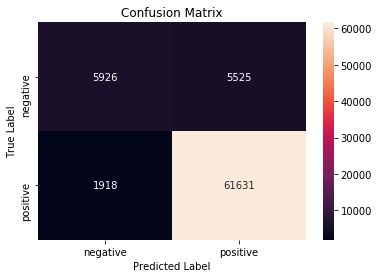

In [164]:
train_err_l1_AvgW2V,test_err_l1_AvgW2V = Run_LogisticReg(X_train, y_train,X_test,y_test,optc_grid_l1_AvgW2V[1],'l1')

************************************************************************************************************************
Optimal C is 100
Accuracy for LogisticReg algorithm with lambda  is  90.08
F1 score for LogisticReg algorithm with lambda  is  77.87
Recall for LogisticReg agorithm with lambda is  74.37
Precision for LogisticReg algorithm with lambda is  83.66

 Classification report for LogisticReg algorithm with lambda is 
               precision    recall  f1-score   support

         -1       0.76      0.52      0.61     11451
          1       0.92      0.97      0.94     63549

avg / total       0.89      0.90      0.89     75000



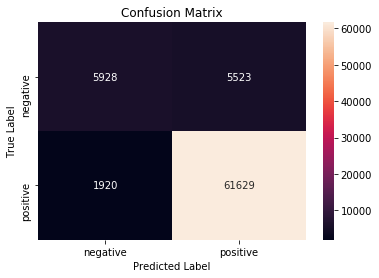

In [165]:
train_err_l2_AvgW2V,test_err_l2_AvgW2V = Run_LogisticReg(X_train, y_train,X_test,y_test,optc_grid_l2_AvgW2V[1],'l2')

In [166]:
Run_L1RegTest(X_train, y_train,X_test,y_test,optc_grid_l1_AvgW2V[1])

Sparcity of weigt vector is 50
Error when C = 10000  is  9.930000000000007
Sparcity of weigt vector is 50
Error when C = 1000.0  is  9.920000000000002
Sparcity of weigt vector is 50
Error when C = 100.0  is  9.920000000000002
Sparcity of weigt vector is 50
Error when C = 10.0  is  9.920000000000002
Sparcity of weigt vector is 50
Error when C = 1.0  is  9.920000000000002


# TfIdf W2V

In [167]:
with open('C:/Users/U6069188/Python Projects/Pickle/tfidf_sent_vectors','rb') as f:
    tfidf_sent_vectors = pickle.load(f)

In [168]:
X = np.array(tfidf_sent_vectors)

In [169]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=.7)

In [170]:
X_train = StandardScaler(with_mean = False).fit_transform(X_train)
X_train.shape

(175000, 50)

In [171]:
X_test = StandardScaler(with_mean = False).fit_transform(X_test)
X_test.shape

(75000, 50)

In [172]:
optc_grid_l1_tfidfW2V,optc_rand_l1_tfidfW2V,model_grid_l1_tfidfW2V  = Run_CV_l1(X_train, y_train,X_test,y_test)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
optimal C value using GridSearchCV ('C', 1)
************************************************************************************************************************
LogisticRegression(C=0.19463891782434628, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
optimal C value using RandomizedSearchCV ('C', 0.19463891782434628)


In [173]:
optc_grid_l2_tfidfW2V,optc_rand_l2_tfidfW2V,model_grid_l2_tfidfW2V  = Run_CV_l2(X_train, y_train,X_test,y_test)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
optimal C value using GridSearchCV ('C', 10000)
************************************************************************************************************************
LogisticRegression(C=0.21260180862155098, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
optimal C value using RandomizedSearchCV ('C', 0.21260180862155098)


************************************************************************************************************************
Optimal C is 1
Accuracy for LogisticReg algorithm with lambda  is  88.61
F1 score for LogisticReg algorithm with lambda  is  73.35
Recall for LogisticReg agorithm with lambda is  69.64
Precision for LogisticReg algorithm with lambda is  80.94

 Classification report for LogisticReg algorithm with lambda is 
               precision    recall  f1-score   support

         -1       0.72      0.42      0.53     11464
          1       0.90      0.97      0.94     63536

avg / total       0.87      0.89      0.87     75000



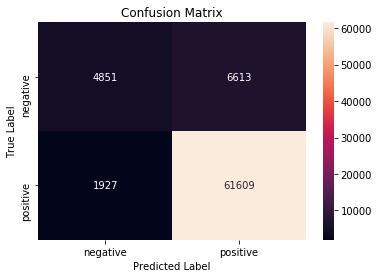

In [174]:
train_err_l1_tfidfW2V,test_err_l1_tfidfW2V = Run_LogisticReg(X_train, y_train,X_test,y_test,optc_grid_l1_tfidfW2V[1],'l1')

************************************************************************************************************************
Optimal C is 10000
Accuracy for LogisticReg algorithm with lambda  is  88.62
F1 score for LogisticReg algorithm with lambda  is  73.38
Recall for LogisticReg agorithm with lambda is  69.67
Precision for LogisticReg algorithm with lambda is  80.96

 Classification report for LogisticReg algorithm with lambda is 
               precision    recall  f1-score   support

         -1       0.72      0.42      0.53     11464
          1       0.90      0.97      0.94     63536

avg / total       0.87      0.89      0.87     75000



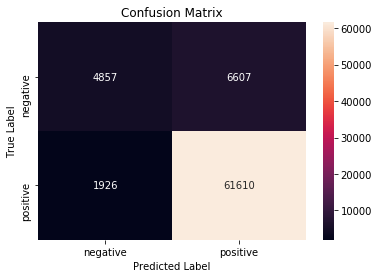

In [175]:
train_err_l2_tfidfW2V,test_err_l2_tfidfW2V = Run_LogisticReg(X_train, y_train,X_test,y_test,optc_grid_l2_tfidfW2V[1],'l2')

In [176]:
Run_L1RegTest(X_train, y_train,X_test,y_test,optc_grid_l1_tfidfW2V[1])

Sparcity of weigt vector is 50
Error when C = 1  is  11.39
Sparcity of weigt vector is 50
Error when C = 0.1  is  11.39
Sparcity of weigt vector is 47
Error when C = 0.01  is  11.409999999999997
Sparcity of weigt vector is 32
Error when C = 0.001  is  12.040000000000006
Sparcity of weigt vector is 8
Error when C = 0.0001  is  15.260000000000005


In [193]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [194]:
x.field_names = ["Model", "Regularizer" , "Optimal C Value (1/Lambda)", "Train Error", "Test Error"]

In [195]:
x.add_row(["Logistic Reg For Bow","L1",optc_grid_l1_bow, train_err_l1_bow*100,101+test_err_l1_bow])
x.add_row(["Logistic Reg For Bow","L2",optc_grid_l2_bow, train_err_l2_bow*100,101+test_err_l2_bow])
x.add_row(["Logistic Reg For TfIdf","L1",optc_grid_l1_tfidf, train_err_l1_tfidf*100,101+test_err_l1_tfidf])
x.add_row(["Logistic Reg For TfIdf","L2",optc_grid_l2_tfidf, train_err_l2_tfidf*100,101+test_err_l2_tfidf])
x.add_row(["Logistic Reg For AvgW2V","L1",optc_grid_l1_AvgW2V, train_err_l1_AvgW2V*100,101+test_err_l1_AvgW2V])
x.add_row(["Logistic Reg For AvgW2V","L2",optc_grid_l2_AvgW2V, train_err_l2_AvgW2V*100,101+test_err_l2_AvgW2V])
x.add_row(["Logistic Reg For tfidfW2V","L1",optc_grid_l1_tfidfW2V, train_err_l1_tfidfW2V*100,101+test_err_l1_tfidfW2V])
x.add_row(["Logistic Reg For tfidfW2V","L2",optc_grid_l2_tfidfW2V, train_err_l2_tfidfW2V*100,101+test_err_l2_tfidfW2V])

In [196]:
print(x)

+---------------------------+-------------+----------------------------+-----------------------+--------------------+
|           Model           | Regularizer | Optimal C Value (1/Lambda) |      Train Error      |     Test Error     |
+---------------------------+-------------+----------------------------+-----------------------+--------------------+
|    Logistic Reg For Bow   |      L1     |        ('C', 0.01)         |   0.1502857142857139  | 10.161333333333332 |
|    Logistic Reg For Bow   |      L2     |          ('C', 1)          | 0.0022857142857102275 | 12.171999999999997 |
|   Logistic Reg For TfIdf  |      L1     |        ('C', 0.01)         |  0.02114285714285291  | 9.618666666666655  |
|   Logistic Reg For TfIdf  |      L2     |         ('C', 100)         | 0.0022857142857102275 | 12.614666666666665 |
|  Logistic Reg For AvgW2V  |      L1     |        ('C', 10000)        |   9.997714285714288   | 11.924000000000007 |
|  Logistic Reg For AvgW2V  |      L2     |         ('C'

Observations:

1. We can see that when lambda is increasing spacity is reduced and error is increasing for all vectorizers.
2. As we acn see from the above table Test Error is Min for TfIdf vectorizer for L1 regularizer.
3. Collinearity exists for both Bow and TfIdf models.This explains that few features are linearly dependent on other features and I have taken the threshold value as 30.